<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/24-keras-part-2/1_improving_the_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving the Model

We’ve explored a lot of the features Keras offers using our tiny 2-layer
model. As we just saw, after only about 20 epochs of training this
model was able to accurately classify about 98% of the images in the
MNIST test set.

Though sometimes a change to our model can bring about a big
improvement in accuracy, much of the time improving a model’s performance
is a game of accumulating a sequence of tiny improvements.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical

keras_backend.set_image_data_format('channels_last')

TensorFlow 2.x selected.


## Load and process the MNIST data

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()

image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width


# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)


# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0


# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test)).astype(np.int32)

# encode each list into one-hot arrays of the size we just found
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape samples to 2D grid, one line per image
X_train = X_train.reshape([X_train.shape[0], number_of_pixels])
X_test = X_test.reshape([X_test.shape[0], number_of_pixels])

11493376/11490434 [==============================] - 0s 0us/step


## Make one hidden layer model

In [0]:
# These variables are assigned during our pre-processing step. 
# We'll just assign them directly here for this demonstration.
number_of_pixels = 28*28  # size of an MNIST image
number_of_classes = 10    # MNIST images are digits 0 to 9

def make_one_hidden_layer_model():

  # create an empty model
  model = Sequential()

  # add a fully-connected hidden layer with #nodes = #pixels
  model.add(Dense(number_of_pixels, activation='relu', input_shape=[number_of_pixels]))

  # add an output layer with softmax activation
  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model to turn it from specification to code
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# train the model
model = make_one_hidden_layer_model()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=256, verbose=2)  

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 - 3s - loss: 0.2964 - accuracy: 0.9175 - val_loss: 0.1667 - val_accuracy: 0.9509
Epoch 2/20
60000/60000 - 1s - loss: 0.1225 - accuracy: 0.9650 - val_loss: 0.1087 - val_accuracy: 0.9665
Epoch 3/20
60000/60000 - 1s - loss: 0.0791 - accuracy: 0.9773 - val_loss: 0.0803 - val_accuracy: 0.9774
Epoch 4/20
60000/60000 - 1s - loss: 0.0569 - accuracy: 0.9836 - val_loss: 0.0736 - val_accuracy: 0.9771
Epoch 5/20
60000/60000 - 1s - loss: 0.0444 - accuracy: 0.9870 - val_loss: 0.0747 - val_accuracy: 0.9768
Epoch 6/20
60000/60000 - 1s - loss: 0.0324 - accuracy: 0.9910 - val_loss: 0.0641 - val_accuracy: 0.9797
Epoch 7/20
60000/60000 - 1s - loss: 0.0240 - accuracy: 0.9939 - val_loss: 0.0592 - val_accuracy: 0.9810
Epoch 8/20
60000/60000 - 1s - loss: 0.0178 - accuracy: 0.9961 - val_loss: 0.0617 - val_accuracy: 0.9816
Epoch 9/20
60000/60000 - 1s - loss: 0.0148 - accuracy: 0.9965 - val_loss: 0.0614 - val_accuracy: 0.9804
Epoch 10/20
60

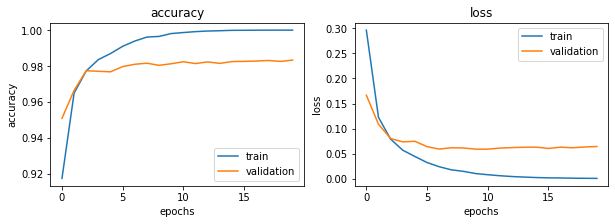

In [0]:
xs = range(len(history.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history.history['accuracy'], label='train')
plt.plot(xs, history.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history.history['loss'], label='train')
plt.plot(xs, history.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss')

plt.show()

## Changing One Hyperparameter

A frequent rule in experimentation of all sorts is to change only one
thing at a time and see what happens. This is a good plan if the values
involved are largely decoupled, meaning that they don’t affect one another.

Unfortunately, the hyperparameters of most real systems, and most
deep-learning systems, are not decoupled. If we increase the amount
of hyperparameter A and find things get better, and then increase
the amount of hyperparameter B, we may find that we now have to
decrease the value in A to make further progress. The connections are
complex.

But still, changing one hyperparameter at a time is usually a good way
to start. We can explore what that value does, find a good value for it,
and then choose another hyperparameter to adjust, and so on, searching
for a good combination by fine-tuning one hyperparameter at a
time.

Let’s try that now, arbitrarily picking the batch size as our first hyperparameter
to experiment with.

In [0]:
# A little utility to draw accuracy and loss plots
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['accuracy']))
    # manually change legend location to 'best' when the locations
    # here don't look good. 

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    plt.show()

In [0]:
# A utility to let us try out lots of variations of models,
# batch size, and early stopping, and plot and save the results.
#
# We use Python's kwargs mechanism is a way to package up the parameters
# to a function in a dictionary. It's a little fancy but it saves a huge
# amount of code. See the Python docs for how this feature works.
#   

random_seed = 42

def run_and_report(model, plot_title=None, filename='generic-filename', 
                   epochs=100, batch_size=256, verbosity=2, stop_early=False):
    np.random.seed(random_seed)
    kwargs = { 'validation_data': (X_test, y_test), 'epochs': epochs,
              'batch_size': batch_size, 'verbose': verbosity }
    if stop_early:
        early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        kwargs['callbacks'] = [early_stopper]
    history = model.fit(X_train, y_train, **kwargs)
    plot_accuracy_and_loss(history, plot_title, filename)
    #models_folder_name = 'NB09-checkpointed-models'
    #file_helper.check_for_directory(models_folder_name)

    #filename = models_folder_name+'/'+filename+'-'+str(epochs)+'-epochs.h5'
    #model.save(filename)
    return history

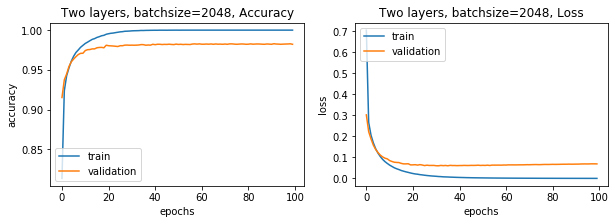

batchsize  2048  elapsed time= 33.26907014846802


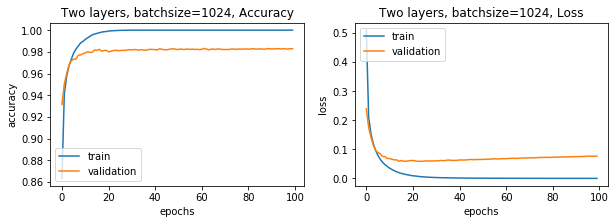

batchsize  1024  elapsed time= 49.7650580406189


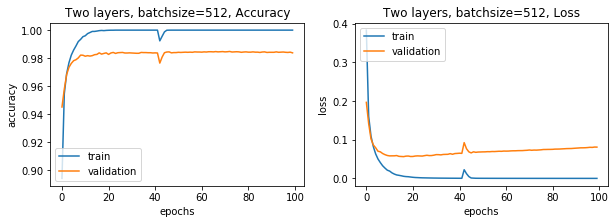

batchsize  512  elapsed time= 73.5817289352417


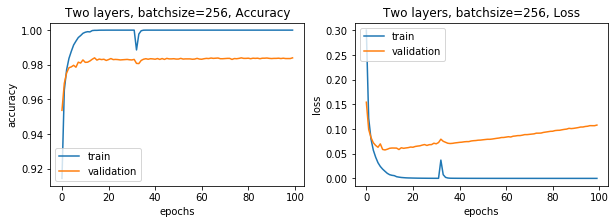

batchsize  256  elapsed time= 124.68649220466614


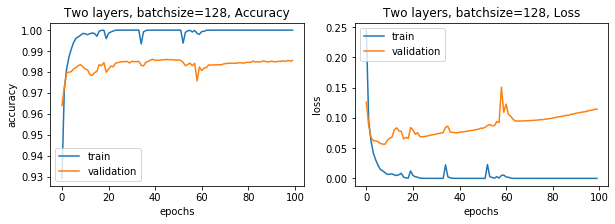

batchsize  128  elapsed time= 220.88846015930176


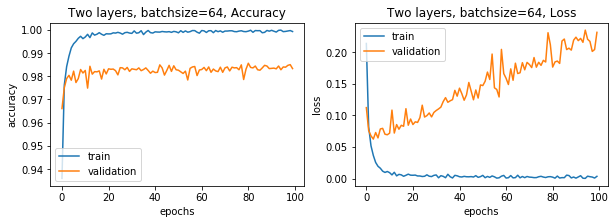

batchsize  64  elapsed time= 396.67887234687805


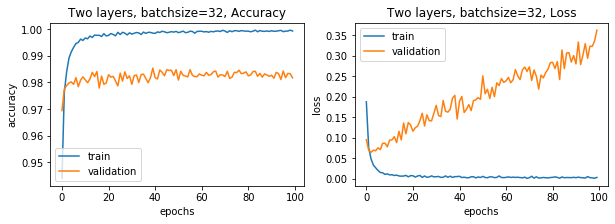

batchsize  32  elapsed time= 771.392050743103


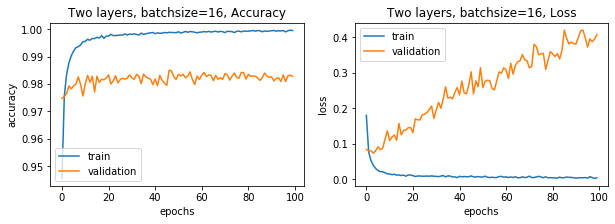

batchsize  16  elapsed time= 1534.0759272575378


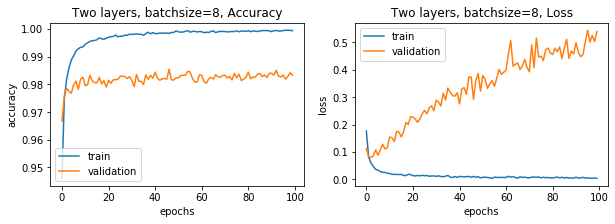

batchsize  8  elapsed time= 2960.397512435913


In [0]:
#
# WARNING: As batch sizes decrease, running time increases FAST.
# Without a GPU, be careful with batch sizes smaller than 256.
#
import time
history_list = []
time_list = []
for batchsize in [2048, 1024, 512, 256, 128, 64, 32, 16, 8]:
    model = make_one_hidden_layer_model()
    plot_title = 'Two layers, batchsize='+str(batchsize)
    filename = 'two-layers-batch-'+str(batchsize)
    start_time = time.time()
    history = run_and_report(model, plot_title, filename, batch_size=batchsize, verbosity=0)
    end_time = time.time()
    elapsed_time = end_time-start_time
    history_list.append(history)
    print("batchsize ",batchsize," elapsed time=",elapsed_time)
    time_list.append(elapsed_time)

In [0]:
# run it one-by-one if GPU is not avaialbale
plot_accuracy_and_loss(history_list[0], 'Two layers, batchsize=2048', 'two-layers-batch-2048')
plot_accuracy_and_loss(history_list[1], 'Two layers, batchsize=1024', 'two-layers-batch-1024')
plot_accuracy_and_loss(history_list[2], 'Two layers, batchsize=512', 'two-layers-batch-512')
plot_accuracy_and_loss(history_list[3], 'Two layers, batchsize=256', 'two-layers-batch-256')
plot_accuracy_and_loss(history_list[4], 'Two layers, batchsize=128', 'two-layers-batch-128')
plot_accuracy_and_loss(history_list[5], 'Two layers, batchsize=64', 'two-layers-batch-64')
plot_accuracy_and_loss(history_list[6], 'Two layers, batchsize=32', 'two-layers-batch-32')
plot_accuracy_and_loss(history_list[7], 'Two layers, batchsize=16', 'two-layers-batch-16')
plot_accuracy_and_loss(history_list[8], 'Two layers, batchsize=8', 'two-layers-batch-8')

Three things jump out from these figures.

* First, as the batch size gets smaller, the results get more jittery, or noisy.
This is because each new update is working with fewer samples, so it’s
responding to whatever happens to be in that batch. Larger batches
tend to become more representative of the dataset as a whole, and give
us smoother results. Smaller batches give us a lot of jumping around.
* The second thing is that the training accuracy is about 98% on all the
models, so the batch size didn’t affect that accuracy very much.
* The third thing is that although all of the models are overfitting, as
demonstrated by the diverging training and validation losses, as the
batch size gets smaller the divergence of the training and validation
error increases. In other words, the amount of overfitting increases.

Smaller batches mean that epochs take longer, because we need to
perform backprop and update the weights more frequently.

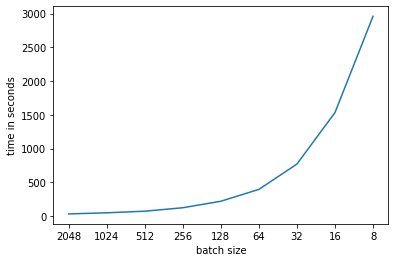

In [0]:
plt.plot(range(len(time_list)), time_list)
plt.xlabel('batch size')
plt.ylabel('time in seconds')
plt.xticks(range(len(time_list)), [2048, 1024, 512, 256, 128, 64, 32, 16, 8])
plt.show()

The curve in figure confirms that on these CPU-only runs, as the
batch size went down, we’re running more backprop and update steps,
so the total training time went up.

## Adding Another Dense Layer

We’ve seen that our single-layer model is already too capable
of learning the idiosyncrasies in the training data. That’s why it’s
overfitting. If we throw in yet more neurons without making any other
structural changes, then this overfitting should get worse, faster.

The architecture for a model with two dense hidden
layers, each with as many neurons as there are input elements (that
is, each layer has 784 neurons), followed by a 10-neuron output layer
with softmax on the output.

<img src='https://github.com/rahiakela/img-repo/blob/master/three-layer-dense-model.JPG?raw=1' width='800'/>


In [0]:
number_of_pixels = 28*28  # size of an MNIST image
number_of_classes = 10    # MNIST images are digits 0 to 9

def make_two_hidden_layers_model():
  model = Sequential()
  model.add(Dense(number_of_pixels, input_shape=[number_of_pixels], activation='relu'))

  # add layers
  model.add(Dense(number_of_pixels, activation='relu'))
  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [0]:
# train the model
model = make_two_hidden_layers_model()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=2)

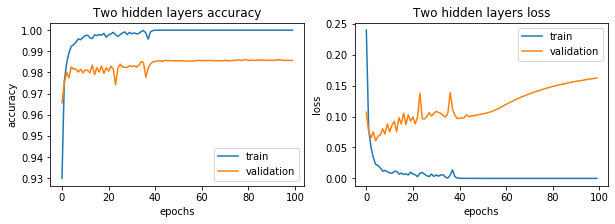

In [19]:
xs = range(len(history.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history.history['accuracy'], label='train')
plt.plot(xs, history.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Two hidden layers accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history.history['loss'], label='train')
plt.plot(xs, history.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Two hidden layers loss')

plt.show()

Compared to our previous results, the new curves are wigglier in the
starting epochs, suggesting that the bigger network took more time to
settle down. And just as we suspected, the system overfit the training
data just like before, but it did so even more quickly, driving up
the validation loss faster than before.

So just throwing more neurons at the problem did not make everything
better. Validation accuracy improved a touch, but the loss is looking
much worse, and we’re still overfitting considerably.

## Less Is More

Having too many neurons has made our network too capable. It had
more than enough power for this task, so it used its extra abilities to
extract more and more idiosyncratic detail from the training set, and
thus overfit.

We generally want the smallest, simplest network that will get us the
results we’re after. A simpler network not only trains and predicts
faster, but it’s less prone to overfitting because there’s less superfluous
computational power to get distracted by irrelevant details in the
training data.

Let’s go back to our single dense layer, but make it far smaller, with
only 64 neurons. This gives us roughly one neuron for every 12 input
pixels.

<img src='https://github.com/rahiakela/img-repo/blob/master/two-layer-network.JPG?raw=1' width='800'/>

We’ll just change the line that defines this layer to give it 64 neurons
rather than 784.


In [0]:
# clear previous session
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def make_smaller_one_hidden_layer_model():
  model = Sequential()
  model.add(Dense(64, input_shape=[number_of_pixels], activation='relu'))

  # add output layers only
  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [38]:
# train the model
model_2 = make_smaller_one_hidden_layer_model()

history_2 = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 - 2s - loss: 0.5277 - accuracy: 0.8583 - val_loss: 0.2682 - val_accuracy: 0.9249
Epoch 2/100
60000/60000 - 1s - loss: 0.2439 - accuracy: 0.9319 - val_loss: 0.2101 - val_accuracy: 0.9392
Epoch 3/100
60000/60000 - 1s - loss: 0.1943 - accuracy: 0.9451 - val_loss: 0.1759 - val_accuracy: 0.9483
Epoch 4/100
60000/60000 - 1s - loss: 0.1635 - accuracy: 0.9542 - val_loss: 0.1536 - val_accuracy: 0.9554
Epoch 5/100
60000/60000 - 1s - loss: 0.1404 - accuracy: 0.9603 - val_loss: 0.1448 - val_accuracy: 0.9582
Epoch 6/100
60000/60000 - 1s - loss: 0.1236 - accuracy: 0.9647 - val_loss: 0.1271 - val_accuracy: 0.9636
Epoch 7/100
60000/60000 - 1s - loss: 0.1099 - accuracy: 0.9686 - val_loss: 0.1186 - val_accuracy: 0.9657
Epoch 8/100
60000/60000 - 1s - loss: 0.0992 - accuracy: 0.9714 - val_loss: 0.1103 - val_accuracy: 0.9670
Epoch 9/100
60000/60000 - 1s - loss: 0.0888 - accuracy: 0.9743 - val_loss: 0.1084 - val_accuracy: 0.9689
Epoch

<Figure size 432x288 with 0 Axes>

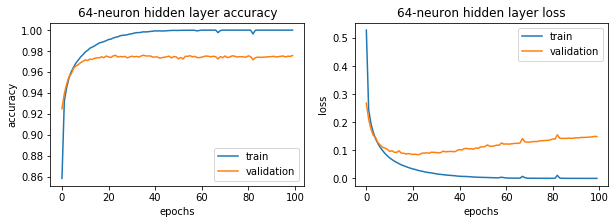

In [39]:
plt.clf() # clear previuos figure

xs = range(len(history_2.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history_2.history['accuracy'], label='train')
plt.plot(xs, history_2.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('64-neuron hidden layer accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history_2.history['loss'], label='train')
plt.plot(xs, history_2.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('64-neuron hidden layer loss')

plt.show()

Our network is giving us a bit less accuracy than the one with 784 neurons
in the first layer, but even so, it’s still overfitting. What to do?

Let’s try using our idea from the last section and use two hidden layers
instead of one, but we’ll keep the same number of neurons and split
them evenly. In other words, we’ll have two hidden layers of 32 neurons
each.

<img src='https://github.com/rahiakela/img-repo/blob/master/deeper-model-with-three-layers.JPG?raw=1' width='800'/>

In [40]:
# clear previous session
keras_backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def make_smaller_one_hidden_layer_model():
  model = Sequential()
  model.add(Dense(number_of_pixels, input_shape=[number_of_pixels], activation='relu'))

  # add output layers only
  model.add(Dense(32, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# train the model
model_3 = make_smaller_one_hidden_layer_model()

history_3 = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 - 2s - loss: 0.3431 - accuracy: 0.9048 - val_loss: 0.1569 - val_accuracy: 0.9531
Epoch 2/100
60000/60000 - 1s - loss: 0.1217 - accuracy: 0.9646 - val_loss: 0.1159 - val_accuracy: 0.9655
Epoch 3/100
60000/60000 - 1s - loss: 0.0808 - accuracy: 0.9757 - val_loss: 0.0880 - val_accuracy: 0.9725
Epoch 4/100
60000/60000 - 1s - loss: 0.0593 - accuracy: 0.9815 - val_loss: 0.0745 - val_accuracy: 0.9777
Epoch 5/100
60000/60000 - 1s - loss: 0.0402 - accuracy: 0.9880 - val_loss: 0.0756 - val_accuracy: 0.9776
Epoch 6/100
60000/60000 - 1s - loss: 0.0328 - accuracy: 0.9901 - val_loss: 0.0697 - val_accuracy: 0.9775
Epoch 7/100
60000/60000 - 1s - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.0726 - val_accuracy: 0.9784
Epoch 8/100
60000/60000 - 1s - loss: 0.0197 - accuracy: 0.9940 - val_loss: 0.0651 - val_accuracy: 0.9809
Epoch 9/100
60000/60000 - 1s - loss: 0.0142 - accuracy: 0.9962 - val_loss: 0.0748 - val_accuracy: 0.9810
Epoch

<Figure size 432x288 with 0 Axes>

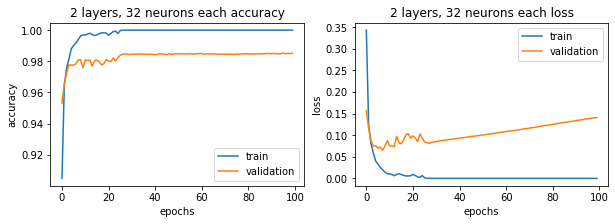

In [41]:
plt.clf()   # clear previuos figure

xs = range(len(history_3.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history_3.history['accuracy'], label='train')
plt.plot(xs, history_3.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('2 layers, 32 neurons each accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history_3.history['loss'], label='train')
plt.plot(xs, history_3.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('2 layers, 32 neurons each loss')

plt.show()

The validation accuracy after 100 epochs has decreased a little bit
from about 97.5% for our single 64-neuron layer to about 97% for our
new, two-layer network. The loss has increased, too, and we seem to
be overfitting even more rapidly than before.

We’ve taken a step backwards. A small step, granted, but the measurements
are worse and we’re still overfitting.

Though chopping up layers into multiple, smaller pieces can sometimes
work, it didn’t help us much in this example.

## Adding Dropout

Since overfitting is a problem for this model and data, let’s try using
dropout. This is a regularization technique
explicitly designed to address overfitting. Dropout temporarily
removes a random selection of neurons before each epoch, and puts
them back in at the end. The intuition is that our neurons will be less
likely to specialize (and potentially over-specialize), since they all need
to be able to compensate for randomly missing neurons.

To apply dropout in Keras, we create a new dropout layer and add it
to the growing stack, just after the layer we want to remove some nodes
from. When dropout is applied, randomly-chosen neurons are isolated
from the network for one epoch, so they don’t contribute to predictions,
and they don’t learn when the network’s weights are updated.
When the epoch is done, the neurons are restored, and before the next
epoch, a new random collection gets disconnected.

The dropout layer in Keras takes only one parameter, and it’s mandatory.
It’s a floating-point number between 0 and 1 that describes
the percentage of neurons that will be temporarily removed after each
batch. A value of 0 disables dropout, while a value of 1 would make the
preceding layer effectively disappear.

The authors also advise constraining the total size of the weights on
the dense layers that are affected by dropout. Speaking generally, the
concern is that when some nodes are removed, the others might overcompensate
by cranking their weights up very high.

By setting an optional parameter
on the Dense layer that’s going to experience dropout. The parameter
is called kernel_constraint, and the advice of the authors of the
paper cited above is to set that to the value 3, so we’ll do just that.

<img src='https://github.com/rahiakela/img-repo/blob/master/fully-connected-dropout-layers.JPG?raw=1' width='800'/>

Schematic symbol for a dropout layer,
which is a slanted line crossing the line carrying data, suggesting that
some of the data is being struck out, or removed.

In [42]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import max_norm

# clear previous session
keras_backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def two_layers_with_dropout_model():
  model = Sequential()
  model.add(Dense(32, input_shape=[number_of_pixels], activation='relu', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))

  model.add(Dense(32, activation='relu', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))

  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model to turn it from specification to code
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

# train the model
model_4 = two_layers_with_dropout_model()

history_4 = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=2)  

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 - 2s - loss: 0.9480 - accuracy: 0.6962 - val_loss: 0.3255 - val_accuracy: 0.9051
Epoch 2/100
60000/60000 - 1s - loss: 0.4455 - accuracy: 0.8679 - val_loss: 0.2491 - val_accuracy: 0.9247
Epoch 3/100
60000/60000 - 1s - loss: 0.3676 - accuracy: 0.8912 - val_loss: 0.2127 - val_accuracy: 0.9353
Epoch 4/100
60000/60000 - 1s - loss: 0.3298 - accuracy: 0.9009 - val_loss: 0.1933 - val_accuracy: 0.9429
Epoch 5/100
60000/60000 - 1s - loss: 0.3011 - accuracy: 0.9106 - val_loss: 0.1808 - val_accuracy: 0.9460
Epoch 6/100
60000/60000 - 1s - loss: 0.2849 - accuracy: 0.9177 - val_loss: 0.1697 - val_accuracy: 0.9502
Epoch 7/100
60000/60000 - 1s - loss: 0.2682 - accuracy: 0.9204 - val_loss: 0.1640 - val_accuracy: 0.9490
Epoch 8/100
60000/60000 - 1s - loss: 0.2571 - accuracy: 0.9232 - val_loss: 0.1591 - val_accuracy: 0.9523
Epoch 9/100
60000/60000 - 1s - loss: 0.2414 - accuracy: 0.9276 - val_loss: 0.1537 - val_accuracy: 0.9548
Epoch

<Figure size 432x288 with 0 Axes>

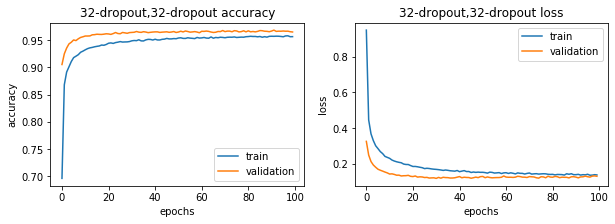

In [43]:
plt.clf()  # clear previuos figure

xs = range(len(history_4.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history_4.history['accuracy'], label='train')
plt.plot(xs, history_4.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('32-dropout,32-dropout accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history_4.history['loss'], label='train')
plt.plot(xs, history_4.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('32-dropout,32-dropout loss')

plt.show()

We’ve conquered over overfitting problem! The losses are no longer
diverging. Dropout has done a great job for us.

The accuracy is a bit weird, since we’re getting better accuracy on the
validation data than the training data. The validation accuracy seems
to have taken a small hit, too, since it’s not up to the 98.3% from before.
We might be able to tweak our accuracy upwards by reducing the dropout
rate a bit, or adding a few more neurons to our dense layers.

The dropout paper also recommends that that we configure our optimizer
to use a learning rate 10-100 times larger than we normally
would. We can tell Adam to start with any specific learning rate by setting
its optional argument lr (that’s a lower-case letter L followed by
a lower-case letter R, standing for “learning rate”). This value defaults
to 0.001.

To pass this argument to Adam, we have to make an Adam object as we
did earlier, and pass it our new value to the learning rate parameter.

In [45]:
from tensorflow.keras.optimizers import Adam

# clear previous session
keras_backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def two_layers_with_dropout_model(optimizer='adam'):
  model = Sequential()
  model.add(Dense(32, input_shape=[number_of_pixels], activation='relu', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))

  model.add(Dense(32, activation='relu', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))

  model.add(Dense(number_of_classes, activation='softmax'))

  # compile the model to turn it from specification to code
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

# make our own Adam object
adam_optimizer = Adam(learning_rate=0.1)

# train the model
model_5 = two_layers_with_dropout_model(optimizer=adam_optimizer)

history_5 = model_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=2)  

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 - 2s - loss: 1.7225 - accuracy: 0.3485 - val_loss: 1.2556 - val_accuracy: 0.5212
Epoch 2/100
60000/60000 - 1s - loss: 1.6245 - accuracy: 0.3937 - val_loss: 1.4958 - val_accuracy: 0.4234
Epoch 3/100
60000/60000 - 1s - loss: 1.8008 - accuracy: 0.3284 - val_loss: 1.6882 - val_accuracy: 0.3063
Epoch 4/100
60000/60000 - 1s - loss: 1.7471 - accuracy: 0.3375 - val_loss: 1.4390 - val_accuracy: 0.4525
Epoch 5/100
60000/60000 - 1s - loss: 1.9094 - accuracy: 0.2603 - val_loss: 1.8848 - val_accuracy: 0.2595
Epoch 6/100
60000/60000 - 1s - loss: 2.0350 - accuracy: 0.2017 - val_loss: 1.8530 - val_accuracy: 0.2533
Epoch 7/100
60000/60000 - 1s - loss: 1.9956 - accuracy: 0.2114 - val_loss: 2.1956 - val_accuracy: 0.1555
Epoch 8/100
60000/60000 - 1s - loss: 1.9895 - accuracy: 0.2266 - val_loss: 1.8228 - val_accuracy: 0.2677
Epoch 9/100
60000/60000 - 1s - loss: 1.9736 - accuracy: 0.2334 - val_loss: 1.7956 - val_accuracy: 0.3114
Epoch

<Figure size 432x288 with 0 Axes>

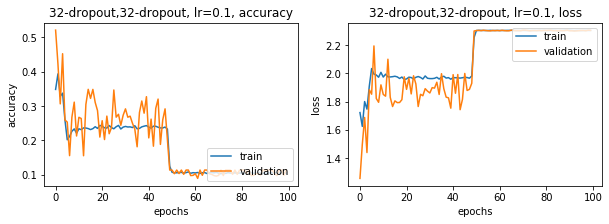

In [46]:
plt.clf()  # clear previuos figure

xs = range(len(history_5.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history_5.history['accuracy'], label='train')
plt.plot(xs, history_5.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('32-dropout,32-dropout, lr=0.1, accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history_5.history['loss'], label='train')
plt.plot(xs, history_5.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('32-dropout,32-dropout, lr=0.1, loss')

plt.show()

For this data and architecture, starting Adam with a learning rate of 0.1
was much too aggressive. The training accuracy plummeted to about
0.18, which is terrible. The validating accuracy seems to be fluttering
around 0.2, but it’s got a lot of noise. The loss was also terrible, more
than 10 times worse than before.

If we drop the learning rate down to 0.01, we get much more encouraging
performance.

In [47]:
# clear previous session
keras_backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# make our own Adam object
adam_optimizer = Adam(learning_rate=0.01)

# train the model
model_6 = two_layers_with_dropout_model(optimizer=adam_optimizer)

history_6 = model_6.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, verbose=2)  

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 - 2s - loss: 0.5772 - accuracy: 0.8185 - val_loss: 0.2514 - val_accuracy: 0.9238
Epoch 2/100
60000/60000 - 1s - loss: 0.3813 - accuracy: 0.8843 - val_loss: 0.2149 - val_accuracy: 0.9378
Epoch 3/100
60000/60000 - 1s - loss: 0.3618 - accuracy: 0.8908 - val_loss: 0.2072 - val_accuracy: 0.9376
Epoch 4/100
60000/60000 - 1s - loss: 0.3534 - accuracy: 0.8918 - val_loss: 0.2086 - val_accuracy: 0.9371
Epoch 5/100
60000/60000 - 1s - loss: 0.3445 - accuracy: 0.8959 - val_loss: 0.1902 - val_accuracy: 0.9428
Epoch 6/100
60000/60000 - 1s - loss: 0.3443 - accuracy: 0.8975 - val_loss: 0.2023 - val_accuracy: 0.9400
Epoch 7/100
60000/60000 - 1s - loss: 0.3394 - accuracy: 0.8975 - val_loss: 0.1901 - val_accuracy: 0.9430
Epoch 8/100
60000/60000 - 1s - loss: 0.3375 - accuracy: 0.8995 - val_loss: 0.2081 - val_accuracy: 0.9400
Epoch 9/100
60000/60000 - 1s - loss: 0.3356 - accuracy: 0.8984 - val_loss: 0.2134 - val_accuracy: 0.9377
Epoch

<Figure size 432x288 with 0 Axes>

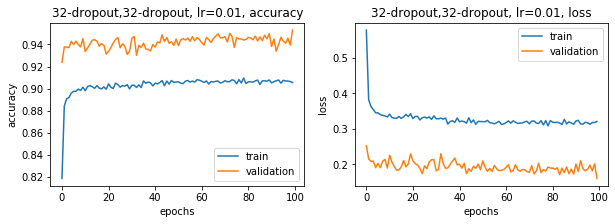

In [48]:
plt.clf()  # clear previuos figure

xs = range(len(history_6.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history_6.history['accuracy'], label='train')
plt.plot(xs, history_6.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('32-dropout,32-dropout, lr=0.01, accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history_6.history['loss'], label='train')
plt.plot(xs, history_6.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('32-dropout,32-dropout, lr=0.01, loss')

plt.show()

These results aren’t nearly as good as what we got with the default
learning rate of 0.001, but it was worth a shot. Things are much calmer,
and our accuracies are both above 90%. And we’re still not overfitting.

We could try out a variety of learning rates to try to see what value
works the best for this model and data, but that would be a lot of typing
and waiting.

It would be really nice if we could automate this search, so the computer
could try out a variety of learning rates for us while we do other
things. So, we’ll see how to do just this using tools
from scikit-learn.